Data Shape: (150, 6)

First 5 Rows:
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Data Summary:
               Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count  150.000000     150.000000    150.000000     150.000000    150.000000
mean    75.500000       5.843333      3.054000       3.758667      1.198667
std     43.445368       0.828066      0.433594       1.764420      0.763161
min      1.000000       4.300000      2.000000       1.000000      0.100000
25%     38.250000       5.100000      2.800000       1.600000      0.300000
50%     75.500000       5.80000

<Figure size 1500x1000 with 0 Axes>

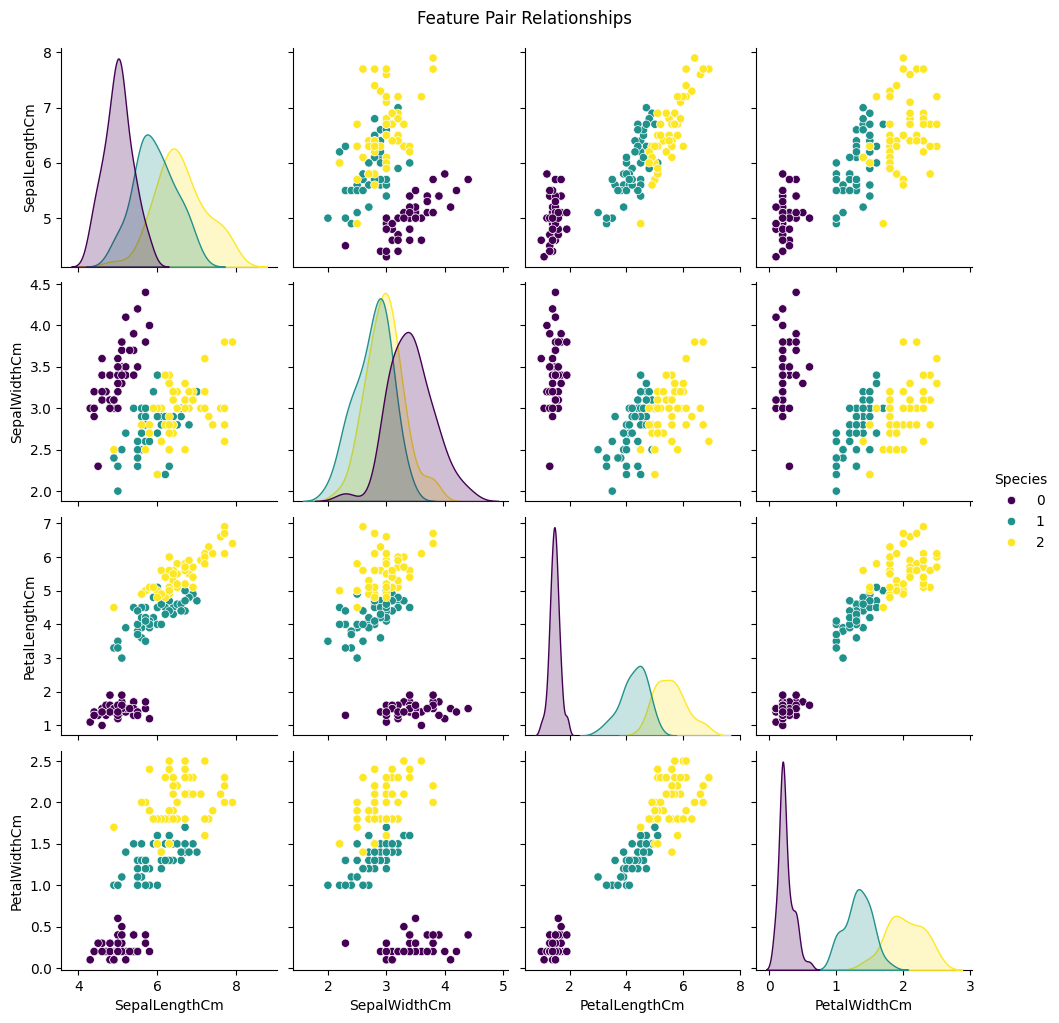

<Figure size 1200x600 with 0 Axes>

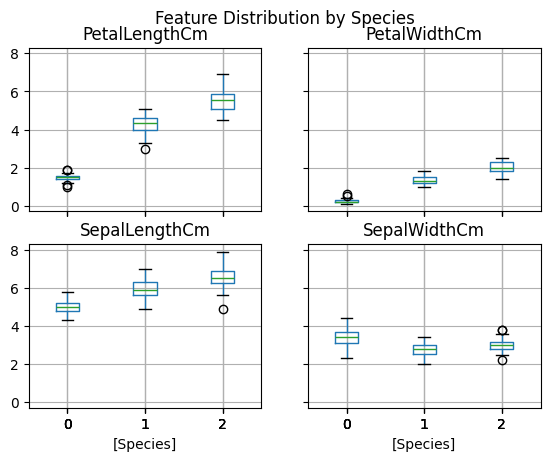

Random Forest Base Model Accuracy: 0.9000
SVM Base Model Accuracy: 0.9667
Logistic Regression Base Model Accuracy: 0.9667

Ensemble Model Accuracy: 0.9667

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



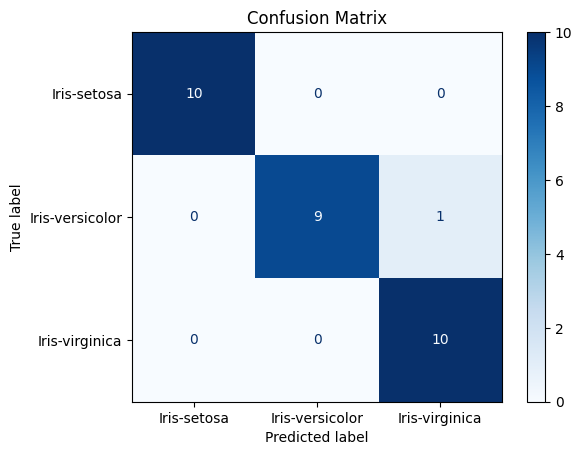

<ipython-input-3-13b5d9ffc842>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='rocket')


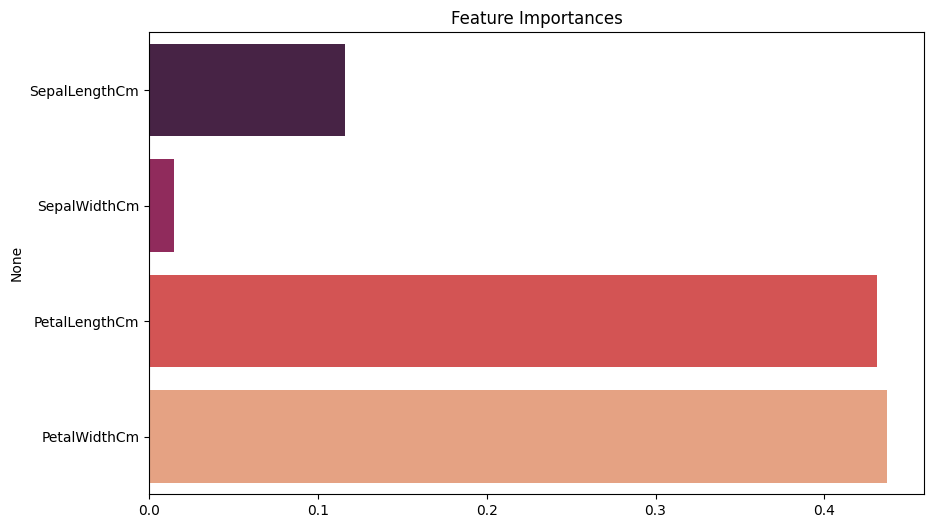


Best Parameters: {'rf__n_estimators': 50, 'svm__svc__C': 0.1, 'svm__svc__gamma': 'scale'}
Best Cross-Val Score: 0.9583

Predictions for New Samples:
Sample: [5.1 3.5 1.4 0.2] -> Iris-setosa
Sample: [6.2 2.9 4.3 1.3] -> Iris-versicolor
Sample: [7.3 2.9 6.3 1.8] -> Iris-virginica


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Load and inspect data
iris_df = pd.read_csv('Iris.csv')
print("Data Shape:", iris_df.shape)
print("\nFirst 5 Rows:")
print(iris_df.head())
print("\nData Summary:")
print(iris_df.describe())

# Data preprocessing
iris_df = iris_df.drop('Id', axis=1)  # Remove ID column
le = LabelEncoder()
iris_df['Species'] = le.fit_transform(iris_df['Species'])

# EDA Visualization
plt.figure(figsize=(15,10))
sns.pairplot(iris_df, hue='Species', palette='viridis')
plt.suptitle('Feature Pair Relationships', y=1.02)
plt.show()

plt.figure(figsize=(12,6))
iris_df.boxplot(by='Species', layout=(2,2))
plt.suptitle('Feature Distribution by Species')
plt.show()

# Feature engineering
X = iris_df.drop('Species', axis=1)
y = iris_df['Species']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Model training - Base models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': make_pipeline(StandardScaler(), SVC(probability=True)),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Base Model Accuracy: {acc:.4f}")

# Ensemble model
voting_clf = VotingClassifier(
    estimators=[('rf', models['Random Forest']),
                ('svm', models['SVM']),
                ('lr', models['Logistic Regression'])],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
ensemble_acc = voting_clf.score(X_test, y_test)
print(f"\nEnsemble Model Accuracy: {ensemble_acc:.4f}")

# Model evaluation
best_model = voting_clf
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Feature importance analysis
rf = models['Random Forest']
# Handle pipeline vs standalone
if rf:  # Only for Random Forest
    importances = rf.feature_importances_
    features = X.columns
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances, y=features, palette='rocket')
    plt.title('Feature Importances')
    plt.show()

# Hyperparameter tuning
param_grid = {
    'svm__svc__C': [0.1, 1, 10],
    'svm__svc__gamma': ['scale', 'auto'],
    'rf__n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(voting_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Val Score: {grid_search.best_score_:.4f}")

# Save final model
joblib.dump(grid_search.best_estimator_, 'iris_classifier.pkl')

# Prediction example
new_samples = np.array([[5.1, 3.5, 1.4, 0.2],
                        [6.2, 2.9, 4.3, 1.3],
                        [7.3, 2.9, 6.3, 1.8]])

loaded_model = joblib.load('iris_classifier.pkl')
predictions = loaded_model.predict(new_samples)
print("\nPredictions for New Samples:")
for sample, pred in zip(new_samples, predictions):
    print(f"Sample: {sample} -> {le.inverse_transform([pred])[0]}")
